# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


### Tài liệu tham khảo :
- CS231N : [Linear classification notes](http://cs231n.github.io/linear-classify)
- [Youtube : CS231N softmax](https://youtu.be/qlLChbHhbg4?list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC&t=1782)


### Sumary :
- Hàm cross entropy (y là vector one_hot của 1 data point): 
$$- \sum_{i=1}^{N} y_ilog(p_i)$$
- Đạo hàm của probability j với score i:
$$\frac{\partial p_j}{\partial s_i} = -p_ip_j \Leftrightarrow  i = j$$
$$\frac{\partial p_j}{\partial s_i} = -p_j(1 - p_i) \Leftrightarrow  i \neq j$$

- Đạo hàm của cross entropy loss với score:
$$ \frac{\partial Loss}{\partial s_i} = p_i - y_i $$

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [12]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.330277
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:**

```python
W = np.random.randn(3073, 10) * 0.0001
```

- Weight được initialize uniform distribution rất nhỏ trong khoảng [0, 0.0001)
- Khi weight có giá trị nhỏ, output probabilities của mỗi class sẽ gần bằng nhau => loss của 1 sample sẽ xấp xỉ -log(1/C) = -log(1/10)
- loss = sum(one_sample_loss) / N

In [15]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.539305 analytic: 2.539305, relative error: 1.241102e-08
numerical: -0.100270 analytic: -0.100270, relative error: 2.341571e-07
numerical: -0.286403 analytic: -0.286403, relative error: 5.871688e-08
numerical: 1.401075 analytic: 1.401075, relative error: 1.563085e-09
numerical: 0.645929 analytic: 0.645929, relative error: 2.912086e-08
numerical: -2.664023 analytic: -2.664023, relative error: 3.502289e-08
numerical: -2.595212 analytic: -2.595212, relative error: 2.243098e-08
numerical: 0.422177 analytic: 0.422177, relative error: 6.930383e-09
numerical: 0.963255 analytic: 0.963255, relative error: 2.974404e-08
numerical: -0.578520 analytic: -0.578520, relative error: 2.626207e-08
numerical: 3.568274 analytic: 3.568274, relative error: 2.176986e-08
numerical: 1.198992 analytic: 1.198992, relative error: 3.954260e-08
numerical: 0.825409 analytic: 0.825409, relative error: 2.085545e-08
numerical: -1.949681 analytic: -1.949681, relative error: 4.393097e-08
numerical: -3.612736 a

In [16]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.330277e+00 computed in 0.076262s
vectorized loss: 2.330277e+00 computed in 0.009055s
Loss difference: 0.000000
Gradient difference: 0.000000


In [20]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = np.linspace(1e-7, 1e-6, 4)
regularization_strengths = [2.5e3, 5e3]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
for lr in learning_rates:
  for reg_str in regularization_strengths:
    sm = Softmax()
    print(lr, reg_str)
    sm.train(X_train, y_train, lr, reg_str, num_iters=2000, verbose=True)
    y_train_pred = sm.predict(X_train)
    train_acc = np.mean(y_train == y_train_pred)
    y_val_pred = sm.predict(X_val)
    val_acc = np.mean(y_val == y_val_pred)
    results[(lr, reg_str)] = (train_acc, val_acc)
    if val_acc > best_val:
      best_val = val_acc
      best_softmax = sm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1e-07 2500.0
iteration 0 / 2000: loss 82.728013
iteration 100 / 2000: loss 73.554436
iteration 200 / 2000: loss 66.219138
iteration 300 / 2000: loss 59.763509
iteration 400 / 2000: loss 54.262153
iteration 500 / 2000: loss 49.089664
iteration 600 / 2000: loss 44.433433
iteration 700 / 2000: loss 40.211243
iteration 800 / 2000: loss 36.718059
iteration 900 / 2000: loss 33.226217
iteration 1000 / 2000: loss 30.260361
iteration 1100 / 2000: loss 27.675310
iteration 1200 / 2000: loss 24.915005
iteration 1300 / 2000: loss 22.936200
iteration 1400 / 2000: loss 20.700878
iteration 1500 / 2000: loss 18.997912
iteration 1600 / 2000: loss 17.272270
iteration 1700 / 2000: loss 15.837258
iteration 1800 / 2000: loss 14.377965
iteration 1900 / 2000: loss 13.336700
1e-07 5000.0
iteration 0 / 2000: loss 158.089205
iteration 100 / 2000: loss 129.167177
iteration 200 / 2000: loss 105.178887
iteration 300 / 2000: loss 86.396407
iteration 400 / 2000: loss 70.777737
iteration 500 / 2000: loss 58.136165
ite

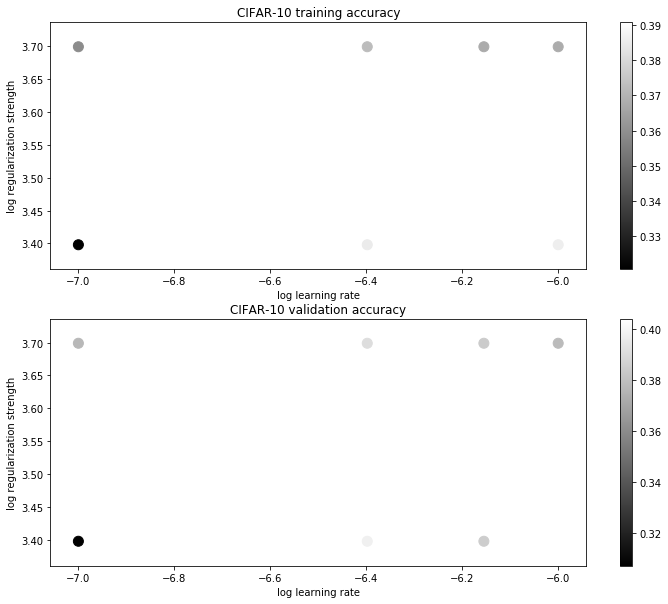

In [21]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
plt.figure(figsize=(12, 10))
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [22]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.383000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: 

- Với SVM: Nếu tồn tại 1 data point mà class score đúng của data point đó lớn hơn tất cả ( score của các class còn lại + margin ) thì loss của SVM sẽ không đổi 

- Với Softmax: Nếu class score của data point đó lớn, chắc chắn loss sẽ thay đổi, vì trong bước tính probability : 
$$\frac{e^{s_j}}{\sum_{N}^{i = 1} e^{s_i}} \neq \frac{e^{s_j}}{\sum_{N}^{i = 1} e^{s_i} + e^{snew}}$$

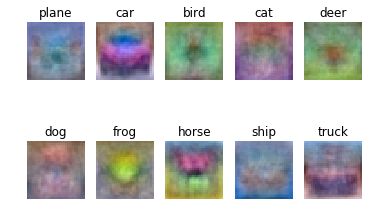

In [23]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])